In [ ]:
# Download the Movielens data.

! wget "https://files.grouplens.org/datasets/movielens/ml-100k.zip"
! unzip ml-100k.zip

--2024-11-15 14:28:18--  https://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip’

ml-100k.zip         100%[===================>]   4.70M  3.02MB/s    in 1.6s    

2024-11-15 14:28:21 (3.02 MB/s) - ‘ml-100k.zip’ saved [4924029/4924029]

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.ba

In [ ]:
# Install fairlearn package for fairness metrics.

! pip install fairlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.3/232.3 kB 3.6 MB/s eta 0:00:00


In [ ]:
# Import necessary libraries.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import ndcg_score
from sklearn.metrics import accuracy_score, confusion_matrix

from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [ ]:
# Read the data from the downloaded csv files.

data = pd.read_csv('ml-100k/u.data', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp']) # user-item interaction data
item = pd.read_csv('ml-100k/u.item', sep='|', encoding='latin-1', names=['item_id', 'title', 'release_date', \
                                                                         'video_release_date', 'imdb_url', 'unknown', \
                                                                         'action', 'adventure', 'animation', \
                                                                         'childrens', 'comedy', 'crime', 'documentary', \
                                                                         'drama', 'fantasy', 'film_noir', 'horror', \
                                                                         'musical', 'mystery', 'romance', 'sci_fi', \
                                                                         'thriller', 'war', 'western']) # Item metadata
user = pd.read_csv('ml-100k/u.user', sep='|', names=['user_id', 'age', 'gender', 'occupation', 'zip_code']) # User metadata

In [ ]:
data.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [ ]:
item.head()

,item_id,title,release_date,video_release_date,imdb_url,unknown,action,adventure,animation,childrens,...,fantasy,film_noir,horror,musical,mystery,romance,sci_fi,thriller,war,western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
user.head()

,user_id,age,gender,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [ ]:
print('data: ', data.shape)
print('item: ', item.shape)
print('user: ', user.shape)

data:  (100000, 4)
item:  (1682, 24)
user:  (943, 5)


In [ ]:
print('Number of user-item interactions: ', data.shape[0])
print('Number of items: ', item.shape[0])
print('Number of users: ',user.shape[0])

Number of user-item interactions:  100000
Number of items:  1682
Number of users:  943


In [ ]:
# Merge the data to create a dataframe that contains sensitive attributes such as gender and age from the user metadata.

merged_data = pd.merge(data, user[['user_id', 'age', 'gender']], on='user_id', how='left')
merged_data.drop('timestamp', axis=1, inplace=True) # drop timestamp column from dataframe.

In [ ]:
merged_data.head()

,user_id,item_id,rating,age,gender
0,196,242,3,49,M
1,186,302,3,39,F
2,22,377,1,25,M
3,244,51,2,28,M
4,166,346,1,47,M


## Data Pre-processing

In [ ]:
# inter_type column (interaction type: positive/negative) is added to the dataset to account for positive and negative interactions.
# Positive interaction : rating > 3
# Negative interaction : rating <=3

merged_data['inter_type'] = np.where(merged_data['rating'] >= 4, 1, 0)
merged_data.head()

,user_id,item_id,rating,age,gender,inter_type
0,196,242,3,49,M,0
1,186,302,3,39,F,0
2,22,377,1,25,M,0
3,244,51,2,28,M,0
4,166,346,1,47,M,0


In [ ]:
# Age is categorized for non-binary fairness analysis.
# Categories of age:
# 0: 0-18 years
# 1: 19-25 years
# 2: 26-35 years
# 3: 36-45 years
# 4: 46-55 years
# 5: 56-65 years
# 6: 66-100 years

def categorize_age(df, age_column='age'):
    bins = [0, 18, 25, 35, 45, 55, 65, 100]
    labels = [0, 1, 2, 3, 4, 5, 6]
    df['age_category'] = pd.cut(df[age_column], bins=bins, labels=labels, right=False)
    return df

merged_data = categorize_age(merged_data)

In [ ]:
merged_data.head()

,user_id,item_id,rating,age,gender,inter_type,age_category
0,196,242,3,49,M,0,4
1,186,302,3,39,F,0,3
2,22,377,1,25,M,0,2
3,244,51,2,28,M,0,2
4,166,346,1,47,M,0,4


In [ ]:
# gender distribution.

gender_count = merged_data['gender'].value_counts()
gender_count

,count
gender,
M,74260
F,25740


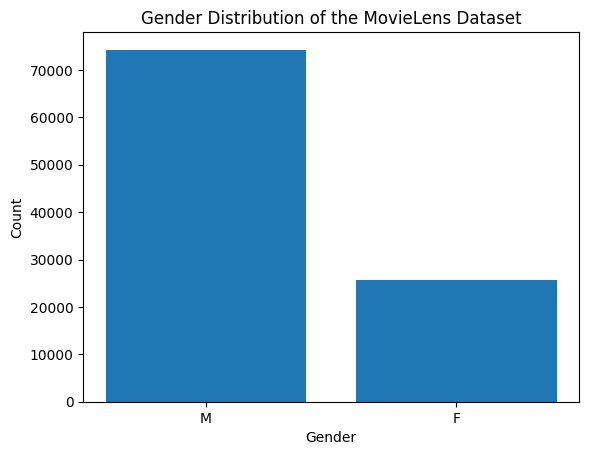

In [ ]:
plt.bar(gender_count.index, gender_count)
plt.xlabel("Gender")
plt.ylabel("Count")
plt.title("Gender Distribution of the MovieLens Dataset")
plt.show()

In [ ]:
# distribution of interactions within the gender demographic categories.

gender_stats = merged_data.groupby('gender')['inter_type'].value_counts().reset_index()
gender_stats

,gender,inter_type,count
0,F,1,14278
1,F,0,11462
2,M,1,41097
3,M,0,33163


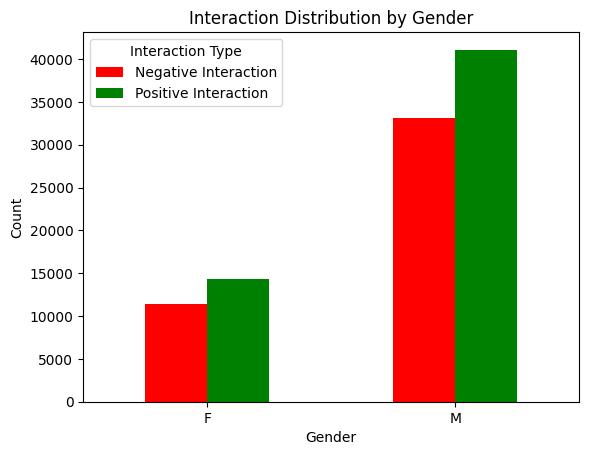

In [ ]:
gender_pivot = gender_stats.pivot(index='gender', columns='inter_type', values='count')
gender_pivot.columns = ['Negative Interaction', 'Positive Interaction']
ax = gender_pivot.plot(kind='bar', stacked=False, color=['red', 'green'])
plt.xlabel("Gender")
plt.ylabel("Count")
plt.title("Interaction Distribution by Gender")
plt.legend(title='Interaction Type', labels=['Negative Interaction', 'Positive Interaction'])
plt.xticks(rotation=0)
plt.show()

<ipython-input-42-dd4ee24e08b3>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(a=merged_data['age'], hist=False);


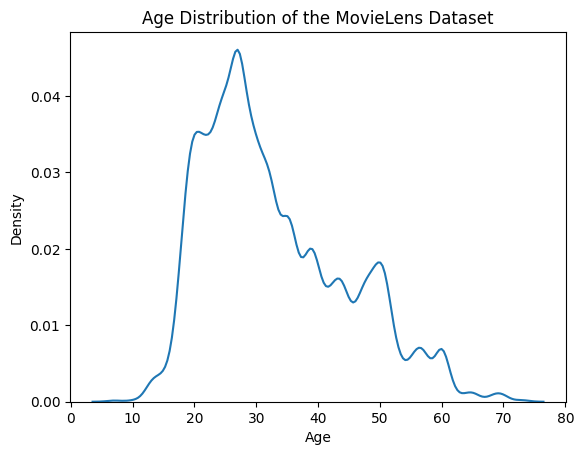

In [ ]:
# age distribution.

sns.distplot(a=merged_data['age'], hist=False);
plt.xlabel("Age");
plt.title("Age Distribution of the MovieLens Dataset");
plt.show();

In [ ]:
# gender distribution.

age_cat_count = merged_data['age_category'].value_counts()
age_cat_count

,count
age_category,
2,35444
1,24060
3,19591
4,12780
5,4923
0,2491
6,711


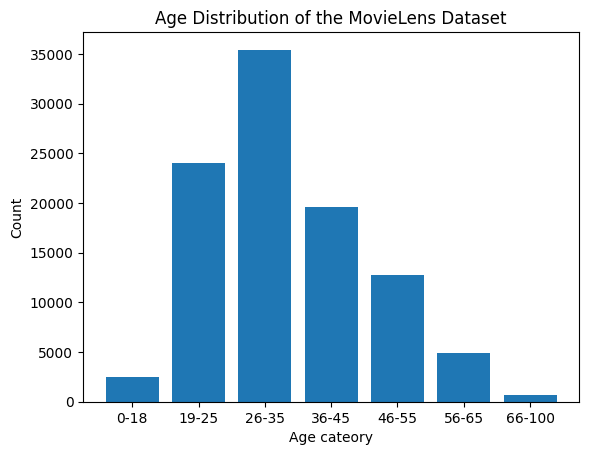

In [ ]:
age_labels = ['0-18', '19-25', '26-35', '36-45', '46-55', '56-65', '66-100']

plt.bar(age_cat_count.index, age_cat_count)
plt.xlabel("Age cateory")
plt.ylabel("Count")
plt.title("Age Distribution of the MovieLens Dataset")
plt.xticks(ticks=range(len(age_labels)), labels=age_labels)
plt.show()

In [ ]:
# distribution of interactions within the age demographic categories.

age_cat_stats = merged_data.groupby('age_category')['inter_type'].value_counts().reset_index()
age_cat_stats

<ipython-input-63-99ed7ff226d9>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_cat_stats = merged_data.groupby('age_category')['inter_type'].value_counts().reset_index()


,age_category,inter_type,count
0,0,1,1307
1,0,0,1184
2,1,1,12930
3,1,0,11130
4,2,1,19190
5,2,0,16254
6,3,1,11043
7,3,0,8548
8,4,1,7505
9,4,0,5275


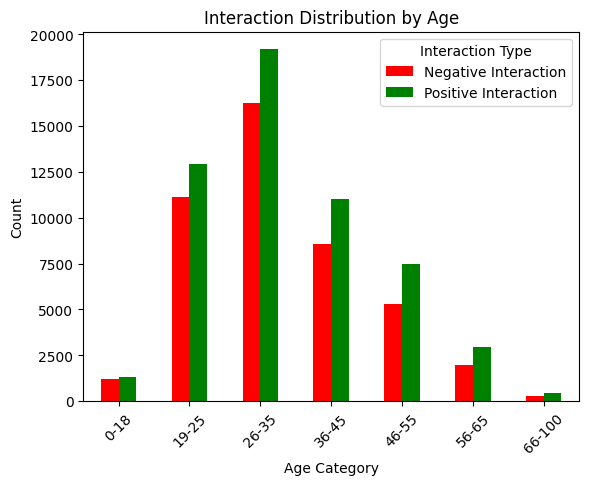

In [ ]:
age_labels = ['0-18', '19-25', '26-35', '36-45', '46-55', '56-65', '66-100']


age_cat_pivot = age_cat_stats.pivot(index='age_category', columns='inter_type', values='count')
age_cat_pivot.columns = ['Negative Interaction', 'Positive Interaction']
ax = age_cat_pivot.plot(kind='bar', stacked=False, color=['red', 'green'])
plt.xlabel("Age Category")
plt.ylabel("Count")
plt.title("Interaction Distribution by Age")
plt.legend(title='Interaction Type', labels=['Negative Interaction', 'Positive Interaction'])
plt.xticks(ticks=range(len(age_labels)), labels=age_labels, rotation = 45)
plt.show()

## Data Sampling

In [ ]:
# Sample the data to contain the sensitive attribute demographic proportions.

sampled_merged_data,_ = train_test_split(merged_data, test_size=0.95,random_state=0,stratify=merged_data['gender'])

## Model

In [ ]:
# Split the data into train, test and validation sets.

train_temp, test_data = train_test_split(sampled_merged_data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_temp, test_size=0.1, random_state=42)

In [ ]:
# For BPR model training, using only gender as sensitive attribute.

train_g = train_data[['user_id','item_id','inter_type','gender']]
val_g = val_data[['user_id','item_id','inter_type','gender']]
test_g = test_data[['user_id','item_id','inter_type','gender']]

In [ ]:
# BPR Model.
# https://github.com/guoyang9/BPR-pytorch

class BPR(nn.Module):
	def __init__(self, user_num, item_num, factor_num):
		super(BPR, self).__init__()
		self.embed_user = nn.Embedding(user_num, factor_num)
		self.embed_item = nn.Embedding(item_num, factor_num)

		nn.init.normal_(self.embed_user.weight, std=0.01)
		nn.init.normal_(self.embed_item.weight, std=0.01)

	def forward(self, user, item_i, item_j):
		user = self.embed_user(user)
		item_i = self.embed_item(item_i)
		item_j = self.embed_item(item_j)

		prediction_i = (user * item_i).sum(dim=-1)
		prediction_j = (user * item_j).sum(dim=-1)
		return prediction_i, prediction_j

In [ ]:
# Generate positive item, negative item tuples for each user.

def user_item_pos_neg(df):
    pairs = []
    users = df['user_id'].unique()
    for user in users:
        pos_items = df[(df['user_id'] == user) & (df['inter_type'] == 1)]['item_id'].values
        neg_items = df[(df['user_id'] == user) & (df['inter_type'] == 0)]['item_id'].values
        for pos_item in pos_items:
            for neg_item in neg_items:
                pairs.append((user, pos_item, neg_item))
    return pairs

train_pos_neg_pairs = user_item_pos_neg(train_g)
val_pos_neg_pairs = user_item_pos_neg(val_g)

In [ ]:
# Prepare to train the BPR Model.

user_num = sampled_merged_data['user_id'].nunique() # number of users in the sampled data
item_num = sampled_merged_data['item_id'].nunique() # number of items in the sampled data
factor_num = 64  # Latent factors in the embedding space

model = BPR(user_num, item_num, factor_num)
optimizer = optim.Adam(model.parameters(), lr=0.001)
reg_lambda = 0.001  # Regularization constant to prevent overfitting on trained data
num_epochs = 20 # Number of training epochs.

user_to_idx = {user: idx for idx, user in enumerate(sampled_merged_data['user_id'].unique())}  # User to index mapping
item_to_idx = {item: idx for idx, item in enumerate(sampled_merged_data['item_id'].unique())}  # Item to index mapping

train_loss_epoch = []  # List to keep track of training loss.
val_loss_epoch = []  # List to keep track of validation loss.

In [ ]:
# Model training and validation.

for epoch in range(num_epochs):

    # Training
    model.train()
    total_train_loss = 0
    for user, pos_item, neg_item in train_pos_neg_pairs:
        user_idx = torch.LongTensor([user_to_idx[user]])
        pos_item_idx = torch.LongTensor([item_to_idx[pos_item]])
        neg_item_idx = torch.LongTensor([item_to_idx[neg_item]])

        prediction_i, prediction_j = model(user_idx, pos_item_idx, neg_item_idx)
        train_loss = -torch.log(torch.sigmoid(prediction_i - prediction_j)).mean()

        train_loss += reg_lambda * (model.embed_user(user_idx).norm(2) +
                                    model.embed_item(pos_item_idx).norm(2) +
                                    model.embed_item(neg_item_idx).norm(2))

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        total_train_loss += train_loss.item()

    avg_train_loss = total_train_loss / len(train_pos_neg_pairs)
    train_loss_epoch.append(avg_train_loss)

    # Validation
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for user, pos_item, neg_item in val_pos_neg_pairs:
            user_idx = torch.LongTensor([user_to_idx[user]])
            pos_item_idx = torch.LongTensor([item_to_idx[pos_item]])
            neg_item_idx = torch.LongTensor([item_to_idx[neg_item]])

            prediction_i, prediction_j = model(user_idx, pos_item_idx, neg_item_idx)
            val_loss = -torch.log(torch.sigmoid(prediction_i - prediction_j)).mean()

            val_loss += reg_lambda * (model.embed_user(user_idx).norm(2) +
                                      model.embed_item(pos_item_idx).norm(2) +
                                      model.embed_item(neg_item_idx).norm(2))
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(val_pos_neg_pairs)
    val_loss_epoch.append(avg_val_loss)

    print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}")


Epoch 1, Train Loss: 0.5754376794332824, Validation Loss: 0.7381722620905262
Epoch 2, Train Loss: 0.19134620782802064, Validation Loss: 0.9090830542861599
Epoch 3, Train Loss: 0.045245673390761104, Validation Loss: 1.0478206199836242
Epoch 4, Train Loss: 0.014887756777320675, Validation Loss: 1.1324174868274632
Epoch 5, Train Loss: 0.009267747977614342, Validation Loss: 1.146792783516727
Epoch 6, Train Loss: 0.008111694808699768, Validation Loss: 1.149105888829656
Epoch 7, Train Loss: 0.007701057284354841, Validation Loss: 1.1359572243200589
Epoch 8, Train Loss: 0.007480731036320031, Validation Loss: 1.116325480939999
Epoch 9, Train Loss: 0.0073528787313141926, Validation Loss: 1.1009302618977141
Epoch 10, Train Loss: 0.007272187366547478, Validation Loss: 1.0909570353998714
Epoch 11, Train Loss: 0.007224509043469118, Validation Loss: 1.0862523109639344
Epoch 12, Train Loss: 0.0071855665533055385, Validation Loss: 1.0881744610681519
Epoch 13, Train Loss: 0.007166082861272339, Validatio

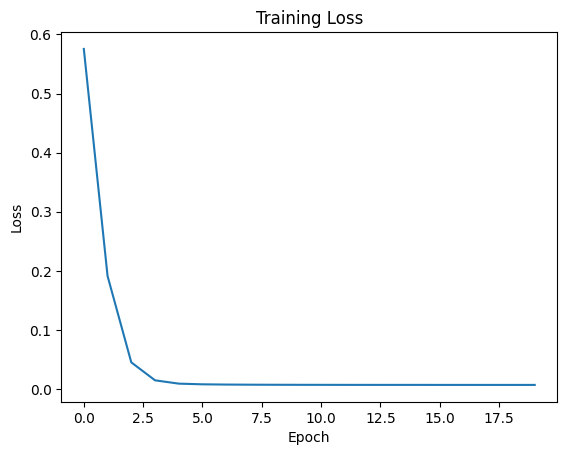

In [ ]:
plt.plot(train_loss_epoch)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

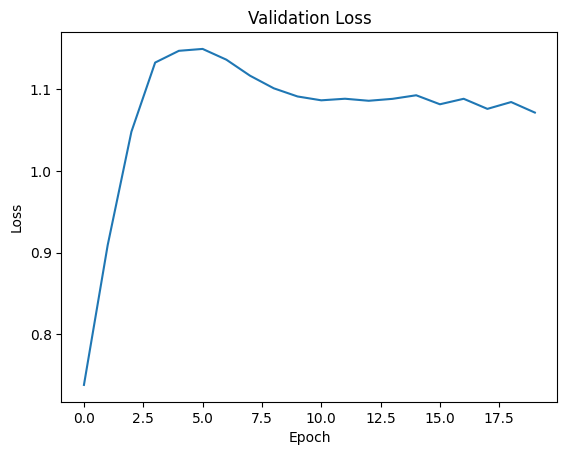

In [ ]:
plt.plot(val_loss_epoch)
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## FDA implementation with BPR model

In [ ]:
# Function to find similar items.

def find_similar_item(item_embedding, all_item_embeddings, original_item_idx, epsilon=0.01):
    similar_embedding = item_embedding + np.random.uniform(-epsilon, epsilon, item_embedding.shape) # Add small noise to embeddings
    similarities = cosine_similarity([similar_embedding], all_item_embeddings)[0] # Find the most similar item by cosine similarity
    similarities[original_item_idx] = -1
    similar_item_idx = np.argmax(similarities)
    return similar_item_idx

In [ ]:
# Function to generate synthetic interactions using hypothesis.

def generate_fake_interactions(group_0, group_1, item_embeddings, epsilon=0.01):
    fake_pairs_1, fake_pairs_2 = [], []

    # Hypothesis 1: Positive interactions
    for user in group_1['user_id'].unique():
        pos_items = group_1[(group_1['user_id'] == user) & (group_1['rating'] == 1)]['item_id'].values
        for pos_item in pos_items:
            original_item_idx = item_to_idx[pos_item]
            similar_item_idx = find_similar_item(item_embeddings[original_item_idx], item_embeddings, original_item_idx, epsilon)
            similar_item = list(item_to_idx.keys())[list(item_to_idx.values()).index(similar_item_idx)]
            fake_pairs_1.append((user, pos_item, similar_item))

    for user in group_0['user_id'].unique():
        pos_items = group_0[(group_0['user_id'] == user) & (group_0['rating'] == 1)]['item_id'].values
        for pos_item in pos_items:
            original_item_idx = item_to_idx[pos_item]
            similar_item_idx = find_similar_item(item_embeddings[original_item_idx], item_embeddings, original_item_idx, epsilon)
            similar_item = list(item_to_idx.keys())[list(item_to_idx.values()).index(similar_item_idx)]
            fake_pairs_1.append((user, pos_item, similar_item))

    # Hypothesis 2: Negative interactions
    for user in group_1['user_id'].unique():
        neg_items = group_1[(group_1['user_id'] == user) & (group_1['rating'] == 0)]['item_id'].values
        for neg_item in neg_items:
            original_item_idx = item_to_idx[neg_item]
            similar_item_idx = find_similar_item(item_embeddings[original_item_idx], item_embeddings, original_item_idx, epsilon)
            similar_item = list(item_to_idx.keys())[list(item_to_idx.values()).index(similar_item_idx)]
            fake_pairs_2.append((user, neg_item, similar_item))

    for user in group_0['user_id'].unique():
        neg_items = group_0[(group_0['user_id'] == user) & (group_0['rating'] == 0)]['item_id'].values
        for neg_item in neg_items:
            original_item_idx = item_to_idx[neg_item]
            similar_item_idx = find_similar_item(item_embeddings[original_item_idx], item_embeddings, original_item_idx, epsilon)
            similar_item = list(item_to_idx.keys())[list(item_to_idx.values()).index(similar_item_idx)]
            fake_pairs_2.append((user, neg_item, similar_item))

    return fake_pairs_1, fake_pairs_2

In [ ]:
# Generate fake data based on the hypotheses

group_1 = train_data[train_data['gender'] == 'M']
group_0 = train_data[train_data['gender'] == 'F']
fake_pairs_1, fake_pairs_2 = generate_fake_interactions(group_0, group_1, model.embed_item.weight.detach().numpy())

In [ ]:
# Function for the modified loss function in the FDA framework.

mask_prob = 0.4 # Random mask probability.

def fda_loss(pos_neg_pairs, fake_pairs_1, fake_pairs_2, model, user_to_idx, item_to_idx, reg_lambda=0.001, mask_prob=0.5):
    total_loss = 0

    # Loss for real interactions.
    for user, pos_item, neg_item in pos_neg_pairs:
        user_idx = torch.LongTensor([user_to_idx[user]])
        pos_item_idx = torch.LongTensor([item_to_idx[pos_item]])
        neg_item_idx = torch.LongTensor([item_to_idx[neg_item]])

        prediction_i, prediction_j = model(user_idx, pos_item_idx, neg_item_idx)
        loss = -torch.log(torch.sigmoid(prediction_i - prediction_j)).mean()

        loss += reg_lambda * (model.embed_user(user_idx).norm(2) +
                              model.embed_item(pos_item_idx).norm(2) +
                              model.embed_item(neg_item_idx).norm(2))
        total_loss += loss

    # Loss for masked fake interactions (Hypothesis 1).
    for user, pos_item, neg_item in fake_pairs_1:
        if random.random() < mask_prob:
            user_idx = torch.LongTensor([user_to_idx[user]])
            pos_item_idx = torch.LongTensor([item_to_idx[pos_item]])
            neg_item_idx = torch.LongTensor([item_to_idx[neg_item]])

            prediction_i, prediction_j = model(user_idx, pos_item_idx, neg_item_idx)
            fake_loss = -torch.log(torch.sigmoid(prediction_i - prediction_j)).mean()

            fake_loss += reg_lambda * (model.embed_user(user_idx).norm(2) +
                                       model.embed_item(pos_item_idx).norm(2) +
                                       model.embed_item(neg_item_idx).norm(2))
            total_loss += fake_loss

    # Loss for masked fake interactions (Hypothesis 2).
    for user, pos_item, neg_item in fake_pairs_2:
        if random.random() < mask_prob:
            user_idx = torch.LongTensor([user_to_idx[user]])
            pos_item_idx = torch.LongTensor([item_to_idx[pos_item]])
            neg_item_idx = torch.LongTensor([item_to_idx[neg_item]])

            prediction_i, prediction_j = model(user_idx, pos_item_idx, neg_item_idx)
            fake_loss = -torch.log(torch.sigmoid(prediction_i - prediction_j)).mean()

            fake_loss += reg_lambda * (model.embed_user(user_idx).norm(2) +
                                       model.embed_item(pos_item_idx).norm(2) +
                                       model.embed_item(neg_item_idx).norm(2))
            total_loss += fake_loss

    return total_loss / (len(pos_neg_pairs) + int(len(fake_pairs_1) * mask_prob) + int(len(fake_pairs_2) * mask_prob))

In [ ]:
# Training Model with FDA framework


model_fda = BPR(user_num, item_num, factor_num=20)
optimizer = optim.Adam(model_fda.parameters(), lr=0.01)
reg_lambda = 0.01
num_epochs = 20

train_loss_epoch_fda = []
val_loss_epoch_fda = []

for epoch in range(num_epochs):

    # Train
    model_fda.train()
    total_train_loss = fda_loss(train_pos_neg_pairs, fake_pairs_1, fake_pairs_2, model_fda, user_to_idx, item_to_idx, reg_lambda)

    optimizer.zero_grad()
    total_train_loss.backward()
    optimizer.step()

    avg_train_loss = total_train_loss.item() / (len(train_pos_neg_pairs) + len(fake_pairs_1) + len(fake_pairs_2))
    train_loss_epoch_fda.append(avg_train_loss)

    # Validation
    model_fda.eval()
    total_val_loss = 0
    with torch.no_grad():
        for user, pos_item, neg_item in val_pos_neg_pairs:
            user_idx = torch.LongTensor([user_to_idx[user]])
            pos_item_idx = torch.LongTensor([item_to_idx[pos_item]])
            neg_item_idx = torch.LongTensor([item_to_idx[neg_item]])

            prediction_i, prediction_j = model_fda(user_idx, pos_item_idx, neg_item_idx)
            val_loss = -torch.log(torch.sigmoid(prediction_i - prediction_j)).mean()

            val_loss += reg_lambda * (model_fda.embed_user(user_idx).norm(2) +
                                      model_fda.embed_item(pos_item_idx).norm(2) +
                                      model_fda.embed_item(neg_item_idx).norm(2))
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(val_pos_neg_pairs)
    val_loss_epoch_fda.append(avg_val_loss)

    print(f"Epoch {epoch+1}, L_fake Loss (Train): {avg_train_loss}, Validation Loss: {avg_val_loss}")


Epoch 1, L_fake Loss (Train): 0.00011286906082547303, Validation Loss: 0.6945320180017654
Epoch 2, L_fake Loss (Train): 0.00011281706404864071, Validation Loss: 0.6948771321610229
Epoch 3, L_fake Loss (Train): 0.00011250002115490607, Validation Loss: 0.6953873854793914
Epoch 4, L_fake Loss (Train): 0.00011236838374520401, Validation Loss: 0.6960378877104145
Epoch 5, L_fake Loss (Train): 0.00011198442839461125, Validation Loss: 0.6967878896896154
Epoch 6, L_fake Loss (Train): 0.00011121537554531214, Validation Loss: 0.6976211887516387
Epoch 7, L_fake Loss (Train): 0.00011080888696752922, Validation Loss: 0.6985313239162916
Epoch 8, L_fake Loss (Train): 0.00010950493131143856, Validation Loss: 0.699518325394147
Epoch 9, L_fake Loss (Train): 0.00010781539419557646, Validation Loss: 0.7005915984715501
Epoch 10, L_fake Loss (Train): 0.00010631400178337531, Validation Loss: 0.7017695748642699
Epoch 11, L_fake Loss (Train): 0.00010414392036755158, Validation Loss: 0.7030444765744144
Epoch 12,

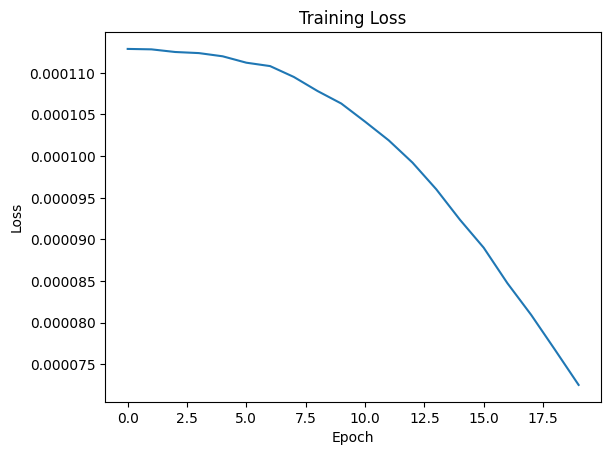

In [ ]:
plt.plot(train_loss_epoch_fda)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

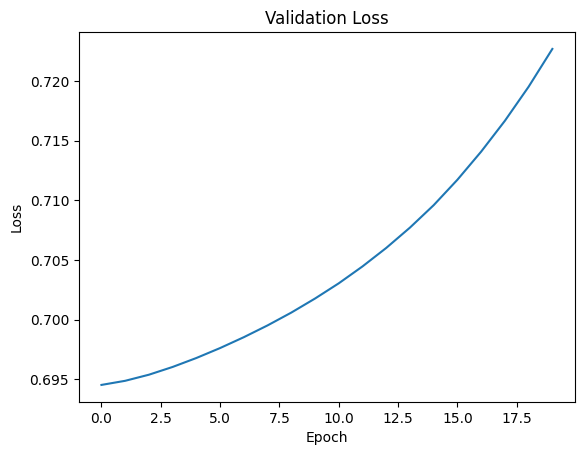

In [ ]:
plt.plot(val_loss_epoch_fda)
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
# Function to calculate the Recommendation evaluation metrics.

def ndcg_hit_rate(model, test_data, user_to_idx, item_to_idx, top_k=10):
    ndcg_scores = []
    hit_rate_scores = []

    users = test_data['user_id'].unique()
    for user in users:

        user_idx = torch.LongTensor([user_to_idx[user]])
        all_items = torch.LongTensor(list(item_to_idx.values()))
        user_embedding = model.embed_user(user_idx)
        item_embeddings = model.embed_item(all_items)
        scores = torch.matmul(user_embedding, item_embeddings.T).squeeze().detach().numpy()

        test_items = test_data[test_data['user_id'] == user]
        item_ids = test_items['item_id'].values
        labels = test_items['inter_type'].values

        item_indices = [item_to_idx[item] for item in item_ids]
        true_rec = np.zeros(len(all_items))
        true_rec[item_indices] = labels

        # Calculate NDCG
        ndcg = ndcg_score([true_rec], [scores], k=top_k)
        ndcg_scores.append(ndcg)

        # Calculate Hit Rate
        top_k_indices = np.argsort(scores)[-top_k:]
        hit = any(idx in item_indices for idx in top_k_indices)
        hit_rate_scores.append(hit)

    avg_ndcg = np.mean(ndcg_scores)
    avg_hit_rate = np.mean(hit_rate_scores)
    return avg_ndcg, avg_hit_rate

In [ ]:
# Evaluate recommendation metrics on test set with only BPR model.

print('Recommendation metrics for BRP model without FDA framework:')

for i in [j*10 for j in range(1,6)]:
  avg_ndcg, avg_hit_rate = ndcg_hit_rate(model, test_g, user_to_idx, item_to_idx, top_k=i)
  print("\n k = ", i , "\n")
  print(f"Average NDCG: {avg_ndcg}")
  print(f"Average Hit Rate: {avg_hit_rate}")

Recommendation metrics for BRP model without FDA framework:

 k =  10 

Average NDCG: 0.00563674670953303
Average Hit Rate: 0.026262626262626262

 k =  20 

Average NDCG: 0.007359598434707567
Average Hit Rate: 0.050505050505050504

 k =  30 

Average NDCG: 0.010189786197344008
Average Hit Rate: 0.07878787878787878

 k =  40 

Average NDCG: 0.01250924452803508
Average Hit Rate: 0.09898989898989899

 k =  50 

Average NDCG: 0.013752106405020162
Average Hit Rate: 0.11717171717171718


In [ ]:
# Evaluate recommendation metrics on test set with BPR FDA model .

print('Recommendation metrics for BRP model with FDA framework:')

for i in [j*10 for j in range(1,6)]:
  avg_ndcg, avg_hit_rate = ndcg_hit_rate(model_fda, test_g, user_to_idx, item_to_idx, top_k=i)
  print("\n k = ", i , "\n")
  print(f"Average NDCG: {avg_ndcg}")
  print(f"Average Hit Rate: {avg_hit_rate}")

Recommendation metrics for BRP model with FDA framework:

 k =  10 

Average NDCG: 0.0016182424154827894
Average Hit Rate: 0.006060606060606061

 k =  20 

Average NDCG: 0.00525407062021162
Average Hit Rate: 0.030303030303030304

 k =  30 

Average NDCG: 0.0066139600861687756
Average Hit Rate: 0.050505050505050504

 k =  40 

Average NDCG: 0.008062423611996576
Average Hit Rate: 0.07272727272727272

 k =  50 

Average NDCG: 0.00931206326482435
Average Hit Rate: 0.08686868686868687


In [ ]:
# Process data for fairness evaluation.

def fairlearn_data(model, test_data, user_to_idx, item_to_idx, top_k=10):
    y_true = []
    y_pred = []
    sensitive_features = []

    users = test_data['user_id'].unique()
    for user in users:
        user_idx = torch.LongTensor([user_to_idx[user]])
        all_items = torch.LongTensor(list(item_to_idx.values()))
        user_embedding = model.embed_user(user_idx)
        item_embeddings = model.embed_item(all_items)
        scores = torch.matmul(user_embedding, item_embeddings.T).squeeze().detach().numpy()

        test_items = test_data[test_data['user_id'] == user]
        item_ids = test_items['item_id'].values
        labels = test_items['inter_type'].values
        sensitive_attr = test_items['gender'].values[0]

        item_indices = [item_to_idx.get(item, 0) for item in item_ids]

        # Generate predictions based on top-k recommendations.
        predicted_labels = np.zeros(len(item_to_idx))
        top_k_indices = np.argsort(scores)[-top_k:]  # Indices of top-k recommended items
        predicted_labels[top_k_indices] = 1  # Mark top-k items as positives

        y_true.extend(labels)
        y_pred.extend([predicted_labels[idx] for idx in item_indices])
        sensitive_features.extend([sensitive_attr] * len(labels))

    return pd.Series(y_true), pd.Series(y_pred), pd.Series(sensitive_features)

In [ ]:
# Evaluate fairness metrics on test set with only BPR model.

print('Fairness metrics for BRP model without FDA framework:')

for i in [j*10 for j in range(1,6)]:
    y_true, y_pred, sensitive_features = fairlearn_data(model, test_g, user_to_idx, item_to_idx, top_k=i)
    dp = demographic_parity_difference(y_true, y_pred, sensitive_features=sensitive_features)
    eo = equalized_odds_difference(y_true, y_pred, sensitive_features=sensitive_features)
    print("\n k = ", i , "\n")
    print(f"Demographic Parity (DP): {dp}")
    print(f"Equality of Opportunity (EO): {eo}")

Fairness metrics for BRP model without FDA framework:

 k =  10 

Demographic Parity (DP): 0.008869588103697855
Equality of Opportunity (EO): 0.01331236897274633

 k =  20 

Demographic Parity (DP): 0.008553757073299119
Equality of Opportunity (EO): 0.010180423603242394

 k =  30 

Demographic Parity (DP): 0.016081063297802345
Equality of Opportunity (EO): 0.02327044025157233

 k =  40 

Demographic Parity (DP): 0.02763521515988946
Equality of Opportunity (EO): 0.03638106859583369

 k =  50 

Demographic Parity (DP): 0.03000394788787998
Equality of Opportunity (EO): 0.04201167959557221


In [108]:
# Evaluate fairness metrics on test set with BPR FDA model.

print('Fairness metrics for BRP model with FDA framework:')

for i in [j*10 for j in range(1,6)]:
    y_true, y_pred, sensitive_features = fairlearn_data(model_fda, test_g, user_to_idx, item_to_idx, top_k=i)
    dp = demographic_parity_difference(y_true, y_pred, sensitive_features=sensitive_features)
    eo = equalized_odds_difference(y_true, y_pred, sensitive_features=sensitive_features)
    print("\n k = ", i , "\n")
    print(f"Demographic Parity (DP): {dp}")
    print(f"Equality of Opportunity (EO): {eo}")

Fairness metrics for BRP model with FDA framework:

 k =  10 

Demographic Parity (DP): 0.011764705882352941
Equality of Opportunity (EO): 0.013422818791946308

 k =  20 

Demographic Parity (DP): 0.016712725358599814
Equality of Opportunity (EO): 0.01797263139545019

 k =  30 

Demographic Parity (DP): 0.01381760757994473
Equality of Opportunity (EO): 0.014294430401812948

 k =  40 

Demographic Parity (DP): 0.030635609948677457
Equality of Opportunity (EO): 0.03160377358490566

 k =  50 

Demographic Parity (DP): 0.03434662455586261
Equality of Opportunity (EO): 0.04213836477987421


## Objective 1 :

In [119]:
# Using age category (non-binary) as sensitive attributes.

sampled_merged_data_unique = sampled_merged_data[['user_id', 'age_category']].drop_duplicates(subset='user_id')
test_a = pd.merge(test_g, sampled_merged_data_unique, on='user_id', how='left')

In [140]:
def ndcg_hit_rate_nb(model, test_data_nb, user_to_idx, item_to_idx, top_k=10):
    ndcg_all = []
    hit_ratio_all = []

    users = test_data_nb['user_id'].unique()

    for user in users:
        user_idx = torch.LongTensor([user_to_idx[user]])
        all_items = torch.LongTensor(list(item_to_idx.values()))

        user_embedding = model.embed_user(user_idx)
        item_embeddings = model.embed_item(all_items)
        scores = torch.matmul(user_embedding, item_embeddings.T).squeeze().detach().numpy()

        test_items = test_data_nb[test_data_nb['user_id'] == user]
        item_ids = test_items['item_id'].values
        labels = test_items['inter_type'].values

        item_indices = [item_to_idx[item] for item in item_ids if item in item_to_idx]

        # Generate top-k predictions.
        top_k_indices = np.argsort(scores)[-top_k:]
        predicted_labels = np.isin(np.array(list(item_to_idx.values())), top_k_indices).astype(int)

        # Calculate NDCG for the user.
        if len(labels) > 1:  # NDCG is only meaningful if there is more than one label
            ndcg_all.append(ndcg_score([labels], [predicted_labels[item_indices]], k=top_k))

        # Calculate Hit Rate for the user.
        hit_rate = 1 if sum(predicted_labels[item_indices][:top_k]) > 0 else 0
        hit_ratio_all.append(hit_rate)

    # Calculate overall averages
    overall_ndcg = np.mean(ndcg_all) if ndcg_all else 0
    overall_hit_ratio = np.mean(hit_ratio_all) if hit_ratio_all else 0

    return overall_ndcg, overall_hit_ratio

In [141]:
# Evaluate recommendation metrics on test set with BPR model for different values of k

print('Recommendation metrics for BPR model without FDA framework:')

for i in [j*10 for j in range(1, 6)]:  # k = 10, 20, 30, 40, 50
    avg_ndcg, avg_hit_rate = ndcg_hit_rate_nb(model, test_a, user_to_idx, item_to_idx, top_k=i)
    print(f"\nk = {i}\n")
    print(f"Average NDCG: {avg_ndcg}")
    print(f"Average Hit Rate: {avg_hit_rate}")

Recommendation metrics for BPR model without FDA framework:

k = 10

Average NDCG: 0.713054391787191
Average Hit Rate: 0.026262626262626262

k = 20

Average NDCG: 0.7120054588016606
Average Hit Rate: 0.050505050505050504

k = 30

Average NDCG: 0.7100273080776164
Average Hit Rate: 0.07878787878787878

k = 40

Average NDCG: 0.7117903996013047
Average Hit Rate: 0.09898989898989899

k = 50

Average NDCG: 0.7114508518728959
Average Hit Rate: 0.11717171717171718


In [142]:
# Evaluate recommendation metrics on test set with BPR FDA model for different values of k

print('Recommendation metrics for BPR model with FDA framework:')

for i in [j*10 for j in range(1, 6)]:  # k = 10, 20, 30, 40, 50
    avg_ndcg, avg_hit_rate = ndcg_hit_rate_nb(model_fda, test_a, user_to_idx, item_to_idx, top_k=i)
    print(f"\nk = {i}\n")
    print(f"Average NDCG: {avg_ndcg}")
    print(f"Average Hit Rate: {avg_hit_rate}")

Recommendation metrics for BPR model with FDA framework:

k = 10

Average NDCG: 0.7115654881541619
Average Hit Rate: 0.006060606060606061

k = 20

Average NDCG: 0.7161851470512944
Average Hit Rate: 0.030303030303030304

k = 30

Average NDCG: 0.7142636514555986
Average Hit Rate: 0.050505050505050504

k = 40

Average NDCG: 0.7153873041698189
Average Hit Rate: 0.07272727272727272

k = 50

Average NDCG: 0.7156341338757181
Average Hit Rate: 0.08686868686868687


In [129]:
# Modified function for fairness evaluation with non-binary sensitive attribute.

def fairlearn_data_non_binary(model, test_data, user_to_idx, item_to_idx, top_k=10, sensitive_col='age_category'):
    y_true = []
    y_pred = []
    sensitive_features = []

    users = test_data['user_id'].unique()
    for user in users:
        user_idx = torch.LongTensor([user_to_idx[user]])
        all_items = torch.LongTensor(list(item_to_idx.values()))
        user_embedding = model.embed_user(user_idx)
        item_embeddings = model.embed_item(all_items)
        scores = torch.matmul(user_embedding, item_embeddings.T).squeeze().detach().numpy()

        test_items = test_data[test_data['user_id'] == user]
        item_ids = test_items['item_id'].values
        labels = test_items['inter_type'].values
        sensitive_attr = test_items[sensitive_col].values[0]

        item_indices = [item_to_idx.get(item, 0) for item in item_ids]

        # Generate predictions based on top-k recommendations
        predicted_labels = np.zeros(len(item_to_idx))
        top_k_indices = np.argsort(scores)[-top_k:]  # Indices of top-k recommended items
        predicted_labels[top_k_indices] = 1  # Mark top-k items as predicted positives

        y_true.extend(labels)
        y_pred.extend([predicted_labels[idx] for idx in item_indices])
        sensitive_features.extend([sensitive_attr] * len(labels))

    return pd.Series(y_true), pd.Series(y_pred), pd.Series(sensitive_features)

In [130]:
# Evaluate fairness metrics on test set with only BPR model.

sensitive_attr = 'age_category'

print('Fairness metrics for BRP model without FDA framework:')

for i in [j*10 for j in range(1,6)]:
    y_true, y_pred, sensitive_features = fairlearn_data_non_binary(
                                              model, test_a, user_to_idx, item_to_idx, top_k=i, sensitive_col=sensitive_attr
                                              )
    dp = demographic_parity_difference(y_true, y_pred, sensitive_features=sensitive_features)
    eo = equalized_odds_difference(y_true, y_pred, sensitive_features=sensitive_features)
    print("\n k = ", i , "\n")
    print(f"Demographic Parity (DP): {dp}")
    print(f"Equality of Opportunity (EO): {eo}")

Fairness metrics for BRP model without FDA framework:

 k =  10 

Demographic Parity (DP): 0.028871391076115485
Equality of Opportunity (EO): 0.03333333333333333

 k =  20 

Demographic Parity (DP): 0.14285714285714285
Equality of Opportunity (EO): 0.2

 k =  30 

Demographic Parity (DP): 0.14285714285714285
Equality of Opportunity (EO): 0.2

 k =  40 

Demographic Parity (DP): 0.14285714285714285
Equality of Opportunity (EO): 0.2

 k =  50 

Demographic Parity (DP): 0.10119047619047619
Equality of Opportunity (EO): 0.17600000000000002


In [131]:
# Evaluate fairness metrics on test set with BPR FDA model.

sensitive_attr = 'age_category'

print('Fairness metrics for BRP model with FDA framework:')

for i in [j*10 for j in range(1,6)]:
    y_true, y_pred, sensitive_features = fairlearn_data_non_binary(
    model_fda, test_a, user_to_idx, item_to_idx, top_k=i, sensitive_col=sensitive_attr
)
    dp = demographic_parity_difference(y_true, y_pred, sensitive_features=sensitive_features)
    eo = equalized_odds_difference(y_true, y_pred, sensitive_features=sensitive_features)
    print("\n k = ", i , "\n")
    print(f"Demographic Parity (DP): {dp}")
    print(f"Equality of Opportunity (EO): {eo}")

Fairness metrics for BRP model with FDA framework:

 k =  10 

Demographic Parity (DP): 0.011111111111111112
Equality of Opportunity (EO): 0.011627906976744186

 k =  20 

Demographic Parity (DP): 0.027777777777777776
Equality of Opportunity (EO): 0.032

 k =  30 

Demographic Parity (DP): 0.045454545454545456
Equality of Opportunity (EO): 0.1111111111111111

 k =  40 

Demographic Parity (DP): 0.09090909090909091
Equality of Opportunity (EO): 0.1111111111111111

 k =  50 

Demographic Parity (DP): 0.13636363636363635
Equality of Opportunity (EO): 0.15384615384615385


## Objective 2

In [132]:
# Using both gender and age category as sensitive attributes.

train_ag = train_data[['user_id','item_id','inter_type','gender','age_category']]
val_ag = val_data[['user_id','item_id','inter_type','gender','age_category']]
test_ag = test_data[['user_id','item_id','inter_type','gender','age_category']]

In [133]:
test_ag['multi_sa'] = list(zip(test_ag['gender'], test_ag['age_category']))

<ipython-input-133-c54ef1a1aceb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_ag['multi_sa'] = list(zip(test_ag['gender'], test_ag['age_category']))


In [143]:
def ndcg_hit_rate_multi_sa(model, test_data, user_to_idx, item_to_idx, top_k=10):
    ndcg_all = []
    hit_ratio_all = []
    ndcg_per_group = {}
    hit_ratio_per_group = {}

    sa_groups = test_data['multi_sa'].unique()

    for sa_group in sa_groups:
        group_ndcg = []
        group_hit_ratio = []
        group_data = test_data[test_data['multi_sa'] == sa_group]
        users = group_data['user_id'].unique()

        for user in users:
            user_idx = torch.LongTensor([user_to_idx[user]])
            all_items = torch.LongTensor(list(item_to_idx.values()))

            user_embedding = model.embed_user(user_idx)
            item_embeddings = model.embed_item(all_items)
            scores = torch.matmul(user_embedding, item_embeddings.T).squeeze().detach().numpy()

            test_items = group_data[group_data['user_id'] == user]
            item_ids = test_items['item_id'].values
            labels = test_items['inter_type'].values

            item_indices = [item_to_idx[item] for item in item_ids if item in item_to_idx]

            # Generate top-k predictions.
            top_k_indices = np.argsort(scores)[-top_k:]
            predicted_labels = np.isin(np.array(list(item_to_idx.values())), top_k_indices).astype(int)

            # Calculate NDCG for the user in the group.
            if len(labels) > 1:
                group_ndcg.append(ndcg_score([labels], [predicted_labels[item_indices]], k=top_k))

            # Calculate Hit Rate for the user in the group.
            hit_rate = 1 if sum(predicted_labels[item_indices][:top_k]) > 0 else 0
            group_hit_ratio.append(hit_rate)

        # Store average NDCG and Hit Rate for the group.
        ndcg_per_group[sa_group] = np.mean(group_ndcg) if group_ndcg else 0
        hit_ratio_per_group[sa_group] = np.mean(group_hit_ratio) if group_hit_ratio else 0

        ndcg_all.extend(group_ndcg)
        hit_ratio_all.extend(group_hit_ratio)

    # Calculate averages across all sensitive attributes.
    overall_ndcg = np.mean(ndcg_all) if ndcg_all else 0
    overall_hit_ratio = np.mean(hit_ratio_all) if hit_ratio_all else 0

    return overall_ndcg, overall_hit_ratio, ndcg_per_group, hit_ratio_per_group

In [144]:
# Evaluate recommendation metrics on test set with BPR model for different values of k
print('Recommendation metrics for BPR model across multiple sensitive attributes:')

for i in [j * 10 for j in range(1, 6)]:  # k = 10, 20, 30, 40, 50
    avg_ndcg, avg_hit_rate, ndcg_per_group, hit_ratio_per_group = ndcg_hit_rate_multi_sa(model, test_ag, user_to_idx, item_to_idx, top_k=i)
    print(f"\nk = {i}\n")
    print(f"Overall Average NDCG: {avg_ndcg}")
    print(f"Overall Average Hit Rate: {avg_hit_rate}")

    print("\nNDCG and Hit Rate per Sensitive Attribute Group")
    for group in ndcg_per_group.keys():
        print(f"Group {group}: NDCG = {ndcg_per_group[group]}, Hit Rate = {hit_ratio_per_group[group]}")

Recommendation metrics for BPR model across multiple sensitive attributes:

k = 10

Overall Average NDCG: 0.7130543917871909
Overall Average Hit Rate: 0.026262626262626262

NDCG and Hit Rate per Sensitive Attribute Group
Group ('M', 1): NDCG = 0.7242800568791469, Hit Rate = 0.0
Group ('M', 2): NDCG = 0.7215465081896814, Hit Rate = 0.04580152671755725
Group ('M', 0): NDCG = 0.8062786476291142, Hit Rate = 0.0
Group ('F', 3): NDCG = 0.7078618988148817, Hit Rate = 0.0
Group ('M', 4): NDCG = 0.7584981472209562, Hit Rate = 0.046511627906976744
Group ('F', 1): NDCG = 0.6265890350932557, Hit Rate = 0.0
Group ('F', 2): NDCG = 0.743218567365194, Hit Rate = 0.10204081632653061
Group ('M', 3): NDCG = 0.5624715073720754, Hit Rate = 0.0
Group ('M', 5): NDCG = 0.8242800716829545, Hit Rate = 0.0
Group ('F', 5): NDCG = 0.9077324383928643, Hit Rate = 0.0
Group ('F', 4): NDCG = 0.7266851726097714, Hit Rate = 0.0
Group ('F', 0): NDCG = 0, Hit Rate = 0.0
Group ('F', 6): NDCG = 0, Hit Rate = 0.0
Group ('M',

In [145]:
# Evaluate recommendation metrics on test set with BPR FDA model for different values of k
print('Recommendation metrics for BPR FDA model across multiple sensitive attributes:')

for i in [j * 10 for j in range(1, 6)]:  # k = 10, 20, 30, 40, 50
    avg_ndcg, avg_hit_rate, ndcg_per_group, hit_ratio_per_group = ndcg_hit_rate_multi_sa(model_fda, test_ag, user_to_idx, item_to_idx, top_k=i)
    print(f"\nk = {i}\n")
    print(f"Overall Average NDCG: {avg_ndcg}")
    print(f"Overall Average Hit Rate: {avg_hit_rate}")

    print("\nNDCG and Hit Rate per Sensitive Attribute Group")
    for group in ndcg_per_group.keys():
        print(f"Group {group}: NDCG = {ndcg_per_group[group]}, Hit Rate = {hit_ratio_per_group[group]}")

Recommendation metrics for BPR FDA model across multiple sensitive attributes:

k = 10

Overall Average NDCG: 0.711565488154162
Overall Average Hit Rate: 0.006060606060606061

NDCG and Hit Rate per Sensitive Attribute Group
Group ('M', 1): NDCG = 0.7242800568791469, Hit Rate = 0.0
Group ('M', 2): NDCG = 0.7192821889703935, Hit Rate = 0.0
Group ('M', 0): NDCG = 0.8062786476291142, Hit Rate = 0.0
Group ('F', 3): NDCG = 0.6982055627434535, Hit Rate = 0.05714285714285714
Group ('M', 4): NDCG = 0.7501101870748528, Hit Rate = 0.0
Group ('F', 1): NDCG = 0.6265890350932557, Hit Rate = 0.034482758620689655
Group ('F', 2): NDCG = 0.7492537774098368, Hit Rate = 0.0
Group ('M', 3): NDCG = 0.5624715073720754, Hit Rate = 0.0
Group ('M', 5): NDCG = 0.8242800716829545, Hit Rate = 0.0
Group ('F', 5): NDCG = 0.9077324383928643, Hit Rate = 0.0
Group ('F', 4): NDCG = 0.7266851726097714, Hit Rate = 0.0
Group ('F', 0): NDCG = 0, Hit Rate = 0.0
Group ('F', 6): NDCG = 0, Hit Rate = 0.0
Group ('M', 6): NDCG = 

In [137]:
def fairlearn_data_multi_sa(model, test_data, user_to_idx, item_to_idx, top_k=10, sensitive_col='multi_sa'):
    y_true = []
    y_pred = []
    sensitive_features = []

    users = test_data['user_id'].unique()
    for user in users:
        user_idx = torch.LongTensor([user_to_idx[user]])
        all_items = torch.LongTensor(list(item_to_idx.values()))
        user_embedding = model.embed_user(user_idx)
        item_embeddings = model.embed_item(all_items)
        scores = torch.matmul(user_embedding, item_embeddings.T).squeeze().detach().numpy()

        test_items = test_data[test_data['user_id'] == user]
        item_ids = test_items['item_id'].values
        labels = test_items['inter_type'].values
        sensitive_attr = test_items[sensitive_col].values[0]

        item_indices = [item_to_idx.get(item, 0) for item in item_ids]

        # Generate predictions based on top-k recommendations
        predicted_labels = np.zeros(len(item_to_idx))
        top_k_indices = np.argsort(scores)[-top_k:]  # Indices of top-k recommended items
        predicted_labels[top_k_indices] = 1  # Mark top-k items as positives

        # Append data for Fairlearn metrics
        y_true.extend(labels)
        y_pred.extend([predicted_labels[idx] for idx in item_indices])
        sensitive_features.extend([sensitive_attr] * len(labels))

    return pd.Series(y_true), pd.Series(y_pred), pd.Series(sensitive_features)

In [138]:
# Evaluate fairness metrics on test set with only BPR model.

sensitive_attr = 'multi_sa'

print('Fairness metrics for BRP model without FDA framework:')

for i in [j*10 for j in range(1,6)]:
    y_true, y_pred, sensitive_features = fairlearn_data_multi_sa(
                                              model, test_ag, user_to_idx, item_to_idx, top_k=i, sensitive_col=sensitive_attr
                                              )
    dp = demographic_parity_difference(y_true, y_pred, sensitive_features=sensitive_features)
    eo = equalized_odds_difference(y_true, y_pred, sensitive_features=sensitive_features)
    print("\n k = ", i , "\n")
    print(f"Demographic Parity (DP): {dp}")
    print(f"Equality of Opportunity (EO): {eo}")

Fairness metrics for BRP model without FDA framework:

 k =  10 

Demographic Parity (DP): 0.053763440860215055
Equality of Opportunity (EO): 0.05555555555555555

 k =  20 

Demographic Parity (DP): 0.16666666666666666
Equality of Opportunity (EO): 0.25

 k =  30 

Demographic Parity (DP): 0.16666666666666666
Equality of Opportunity (EO): 0.25

 k =  40 

Demographic Parity (DP): 0.25
Equality of Opportunity (EO): 0.3333333333333333

 k =  50 

Demographic Parity (DP): 0.25
Equality of Opportunity (EO): 0.3333333333333333


In [139]:
# Evaluate fairness metrics on test set with BPR FDA model.

sensitive_attr = 'age_category'

print('Fairness metrics for BRP model with FDA framework:')

for i in [j*10 for j in range(1,6)]:
    y_true, y_pred, sensitive_features = fairlearn_data_multi_sa(
    model_fda, test_ag, user_to_idx, item_to_idx, top_k=i, sensitive_col=sensitive_attr
)
    dp = demographic_parity_difference(y_true, y_pred, sensitive_features=sensitive_features)
    eo = equalized_odds_difference(y_true, y_pred, sensitive_features=sensitive_features)
    print("\n k = ", i , "\n")
    print(f"Demographic Parity (DP): {dp}")
    print(f"Equality of Opportunity (EO): {eo}")

Fairness metrics for BRP model with FDA framework:

 k =  10 

Demographic Parity (DP): 0.011111111111111112
Equality of Opportunity (EO): 0.011627906976744186

 k =  20 

Demographic Parity (DP): 0.027777777777777776
Equality of Opportunity (EO): 0.032

 k =  30 

Demographic Parity (DP): 0.045454545454545456
Equality of Opportunity (EO): 0.1111111111111111

 k =  40 

Demographic Parity (DP): 0.09090909090909091
Equality of Opportunity (EO): 0.1111111111111111

 k =  50 

Demographic Parity (DP): 0.13636363636363635
Equality of Opportunity (EO): 0.15384615384615385
